# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [2]:
#pip install sqlalchemy
#pip install matplotlib
#pip install pandas


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [4]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [5]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

Criando o banco de dados local

In [6]:
#Criando panco de dados
engine = create_engine("sqlite:///:memory:")

In [7]:
#Adicionando tabela, e retorno de quantidades de linhas da ultima a ser executado
produtos.to_sql("produtos", engine, index=False)
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [8]:
#inspecionando tabelas
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [9]:
query = "SELECT CONDICAO FROM PRODUTOS"

variável chamada consulta que receberá conexao.execute() - responsável por executar esta query no banco de dados.

.execute() precisamos passar a query como texto.

dados = e chamaremos consulta.fetchall(), o que fará a coleta de todos os dados da consulta armazenando-os como listas ou tuplas

Para criar e nomear as colunas, passamos columns=consulta.keys(), assim obtemos o nome das consultas.

In [10]:
#Conecção
with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [11]:
#Criando a função do codigo
def sql_df(query):
    with engine.connect() as conexao:
        consulta = conexao.execute(text(query))
        dados = consulta.fetchall()
        return pd.DataFrame(dados, columns=consulta.keys())

A próxima seleção que precisamos fazer é da função que vai agrupar essas categorias. Neste caso, a COUNT(). Para ela, passaremos um asterisco *, assim serão selecionados todos os dados.
passamos FROM PRODUTOS para indicar a tabela.

Usaremos a cláusula GROUP BY para definir o parâmetro utilizado por COUNT() para definir os agrupamentos. No caso, as categorias presentes na coluna CONDICAO.

In [12]:
query = '''SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS 
GROUP BY CONDICAO;'''

df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


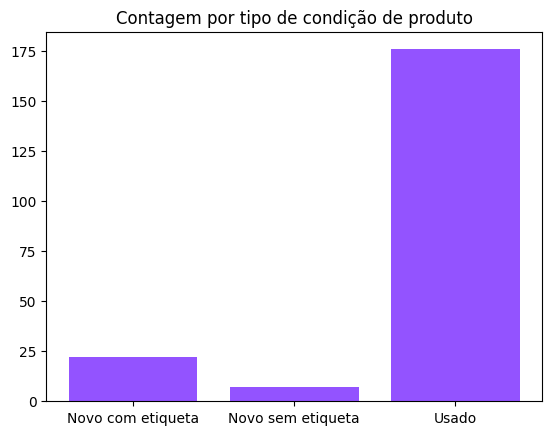

In [13]:
plt.bar(df_produtos['Condicao'],df_produtos['Quantidade'], color='#9353FF')
plt.title("Contagem por tipo de condição de produto")
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [14]:
sql_df("SELECT * FROM PRODUTOS").head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [15]:
sql_df("SELECT * FROM ITENS_PEDIDOS").head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [16]:
#Agrupamento dos dados
query= '''SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC'''

df_prod_quant = sql_df(query)
df_prod_quant

,produto,Quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


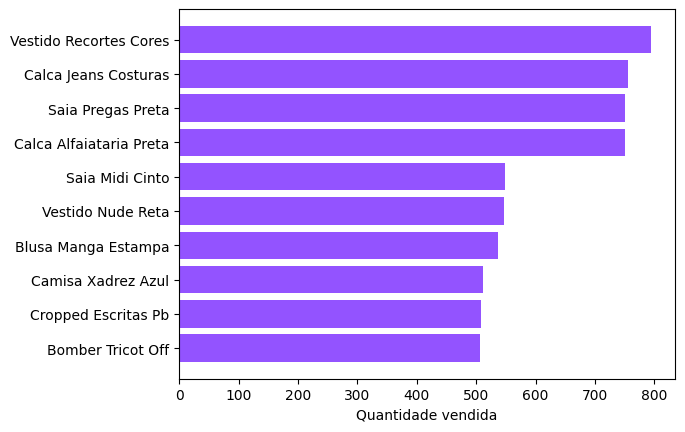

In [17]:
plt.barh(df_prod_quant['produto'][-10:], df_prod_quant['Quantidade'][-10:], color='#9353FF')
plt.xlabel('Quantidade vendida')
plt.show()

In [18]:
df_itens_pedidos = sql_df('SELECT VALOR_TOTAL FROM ITENS_PEDIDOS')
receita = df_itens_pedidos['valor_total'].sum()
receita

np.int64(45803930)

In [19]:
query = '''SELECT SUM(VALOR_TOTAL) AS RECEITA
FROM ITENS_PEDIDOS;
'''
df_itens_pedidos = sql_df(query)
df_itens_pedidos

,RECEITA
0,45803930


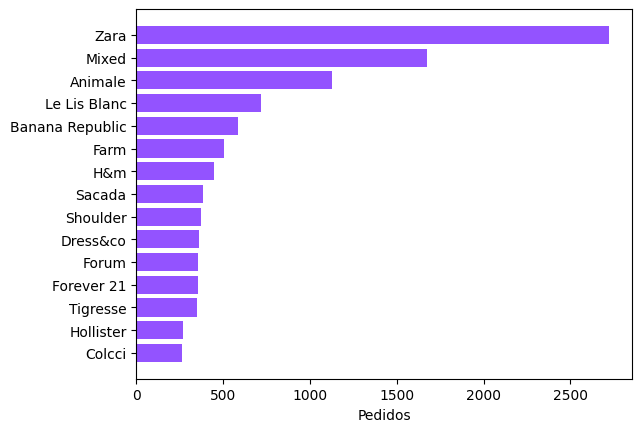

In [20]:
#visualização mostrando as 15 marcas mais vendidas
query = '''SELECT PRODUTOS.MARCA, COUNT (*) AS 'Pedidos'
FROM PRODUTOS, ITENS_PEDIDOS
WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.MARCA
ORDER BY COUNT(*) ASC;
'''
df_marcas = sql_df(query)

plt.barh(df_marcas['marca'][-15:], df_marcas['Pedidos'][-15:], color = '#9353FF')
plt.xlabel('Pedidos')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [21]:
#Dados temporais
sql_df("SELECT * FROM PEDIDOS").head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.